# Phân tích Các Yếu tố Ảnh hưởng đến Điểm số Cuối kỳ

**Câu hỏi**: Những yếu tố nào trong bộ dữ liệu (như số giờ học, phong cách học, mức độ căng thẳng, hoặc thời gian sử dụng mạng xã hội) có ảnh hưởng đáng kể đến điểm số cuối kỳ (`Final_Grade`) của sinh viên, và liệu chúng ta có thể dự đoán điểm số cuối kỳ dựa trên các yếu tố này?

**Dữ liệu**: Bộ dữ liệu `student_performance_large_dataset.csv` chứa các cột:
- `Student_ID`, `Age`, `Gender`, `Study_Hours_per_Week`, `Preferred_Learning_Style`, `Online_Courses_Completed`, `Participation_in_Discussions`, `Assignment_Completion_Rate (%)`, `Exam_Score (%)`, `Attendance_Rate (%)`, `Use_of_Educational_Tech`, `Self_Reported_Stress_Level`, `Time_Spent_on_Social_Media (hours/week)`, `Sleep_Hours_per_Night`, `Final_Grade`.

**Phương pháp**: Sử dụng các kỹ thuật từ *Computational and Inferential Thinking*:
- Trực quan hóa dữ liệu (Chương 7)
- Kiểm định giả thuyết bằng mô phỏng (Chương 11-12)
- Hồi quy tuyến tính đơn giản (Chương 15)
- Phân loại dựa trên ngưỡng (Chương 17)

**Thư viện**: Chỉ sử dụng `numpy`, `datascience`, và `matplotlib`.

In [5]:
# Nhập thư viện
import numpy as np
from datascience import *
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

## Bước 1: Trực quan hóa dữ liệu (Chương 7)

Chúng ta sẽ khám phá dữ liệu bằng các biểu đồ:
- **Histogram**: Phân phối của `Study_Hours_per_Week` và `Attendance_Rate (%)`.
- **Bar chart**: So sánh `Final_Grade` theo `Preferred_Learning_Style`.
- **Scatter plot**: Mối quan hệ giữa `Study_Hours_per_Week` và `Exam_Score (%)`, phân biệt theo `Final_Grade`.

Student_ID,Age,Gender,Study_Hours_per_Week,Preferred_Learning_Style,Online_Courses_Completed,Participation_in_Discussions,Assignment_Completion_Rate (%),Exam_Score (%),Attendance_Rate (%),Use_of_Educational_Tech,Self_Reported_Stress_Level,Time_Spent_on_Social_Media (hours/week),Sleep_Hours_per_Night,Final_Grade
S00001,18,Female,48,Kinesthetic,14,Yes,100,69,66,Yes,High,9,8,C
S00002,29,Female,30,Reading/Writing,20,No,71,40,57,Yes,Medium,28,8,D
S00003,20,Female,47,Kinesthetic,11,No,60,43,79,Yes,Low,13,7,D
S00004,23,Female,13,Auditory,0,Yes,63,70,60,Yes,Low,24,10,B
S00005,19,Female,24,Auditory,19,Yes,59,63,93,Yes,Medium,26,8,C


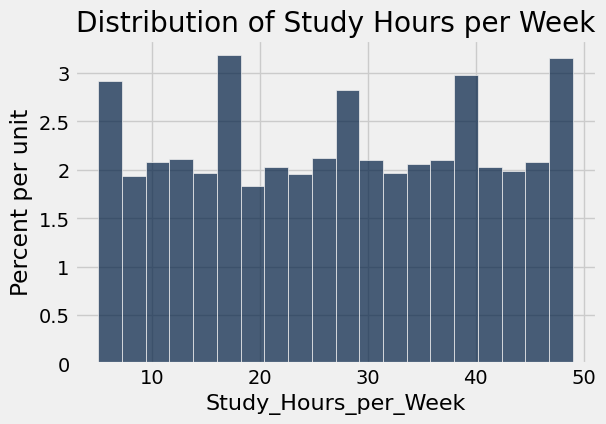

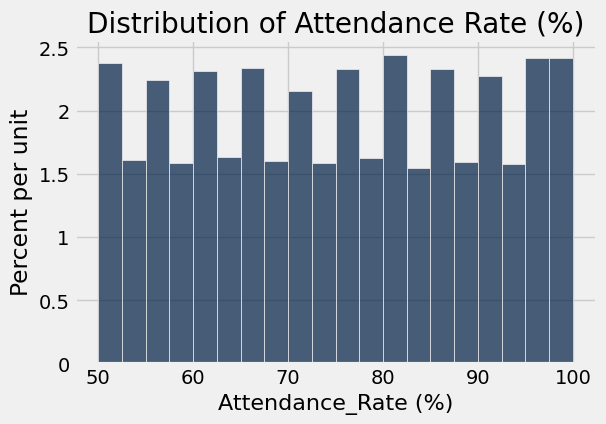

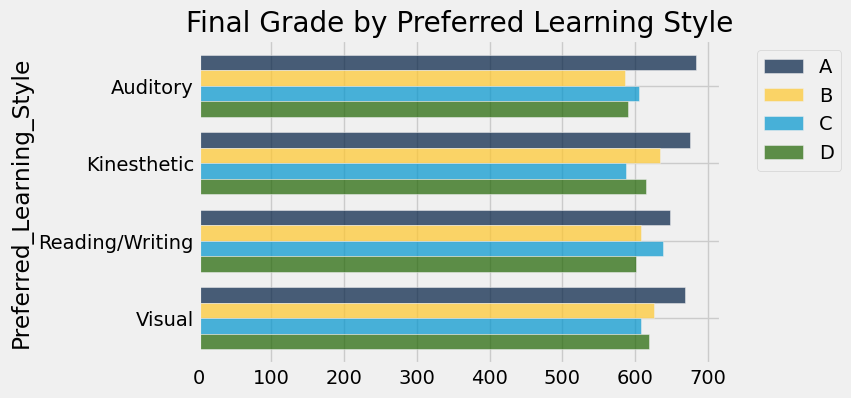

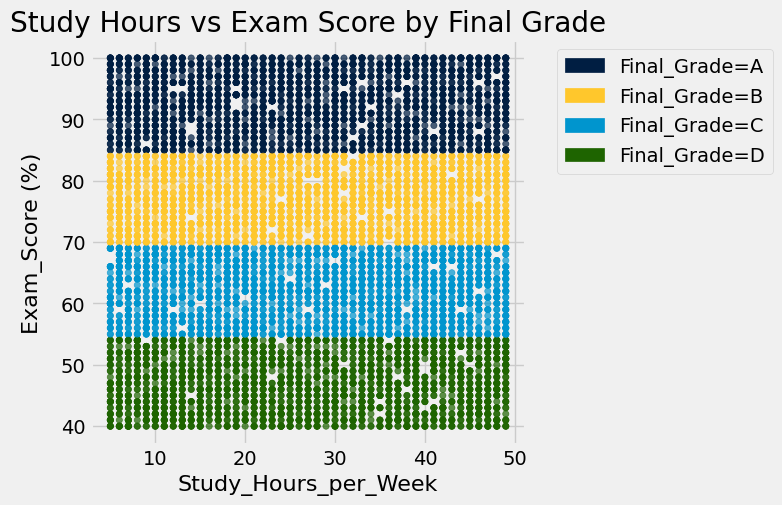

In [33]:
# Load dữ liệu
data = Table.read_table('student_performance_large_dataset.csv')

# Hiển thị 5 dòng đầu
data.show(5)

# Histogram của Study_Hours_per_Week và Attendance_Rate (%)
data.hist('Study_Hours_per_Week', bins=20)
plt.title('Distribution of Study Hours per Week')
plt.show()

data.hist('Attendance_Rate (%)', bins=20)
plt.title('Distribution of Attendance Rate (%)')
plt.show()

# Bar chart của Final_Grade theo Preferred_Learning_Style
learning_style_counts = data.pivot('Final_Grade', 'Preferred_Learning_Style')
learning_style_counts.barh('Preferred_Learning_Style')
plt.title('Final Grade by Preferred Learning Style')
plt.show()

# Scatter plot của Study_Hours_per_Week vs Exam_Score (%)
data.scatter('Study_Hours_per_Week', 'Exam_Score (%)', group='Final_Grade')
plt.title('Study Hours vs Exam Score by Final Grade')
plt.show()

**Nhận xét**:
- Histogram của `Study_Hours_per_Week` và `Attendance_Rate (%)` cho thấy phân phối của chúng. Phân phối lệch có thể ảnh hưởng đến phân tích.
- Bar chart cho thấy phong cách học nào (e.g., Visual, Auditory, Kinesthetic) có tỷ lệ điểm A cao hơn.
- Scatter plot kiểm tra mối quan hệ tuyến tính giữa `Study_Hours_per_Week` và `Exam_Score (%)`. Nếu các điểm A tập trung ở vùng có số giờ học cao, điều này gợi ý mối quan hệ tích cực.

## Bước 2: Kiểm định giả thuyết bằng mô phỏng (Chương 11-12)

Chúng ta kiểm tra xem `Study_Hours_per_Week` có ảnh hưởng đáng kể đến `Final_Grade` bằng permutation test, so sánh trung bình giữa nhóm A và D.

**Giả thuyết**:
- **H0**: Trung bình `Study_Hours_per_Week` của nhóm A và D là như nhau.
- **H1**: Trung bình của hai nhóm khác nhau.

Observed difference in means (A - D): 0.19
P-value: 0.6037


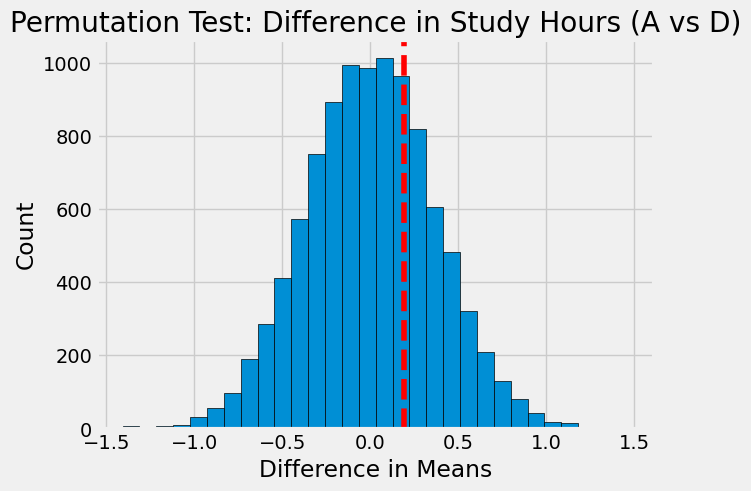

In [34]:
# Filter dữ liệu cho nhóm A và D
data_ad = data.where('Final_Grade', are.contained_in(['A', 'D'])).select('Final_Grade', 'Study_Hours_per_Week')

# Tính chênh lệch trung bình quan sát
group_a = data_ad.where('Final_Grade', 'A').column('Study_Hours_per_Week')
group_d = data_ad.where('Final_Grade', 'D').column('Study_Hours_per_Week')
observed_diff = np.mean(group_a) - np.mean(group_d)
print(f'Observed difference in means (A - D): {observed_diff:.2f}')

# Permutation test
n_simulations = 10000
differences = make_array()
all_hours = data_ad.column('Study_Hours_per_Week')
for _ in range(n_simulations):
    shuffled_hours = np.random.permutation(all_hours)
    shuffled_a = shuffled_hours[:len(group_a)]
    shuffled_d = shuffled_hours[len(group_a):]
    diff = np.mean(shuffled_a) - np.mean(shuffled_d)
    differences = np.append(differences, diff)

# Tính p-value
p_value = np.count_nonzero(np.abs(differences) >= np.abs(observed_diff)) / n_simulations
print(f'P-value: {p_value:.4f}')

# Vẽ histogram của các chênh lệch
plt.hist(differences, bins=30, edgecolor='black')
plt.axvline(observed_diff, color='red', linestyle='--')
plt.title('Permutation Test: Difference in Study Hours (A vs D)')
plt.xlabel('Difference in Means')
plt.ylabel('Count')
plt.show()

**Nhận xét**:
- Nếu p-value < 0.05, chúng ta bác bỏ H0, tức là `Study_Hours_per_Week` có ảnh hưởng đáng kể đến `Final_Grade`.
- Biểu đồ cho thấy phân phối của các chênh lệch trung bình mô phỏng, với đường đỏ là chênh lệch quan sát.

## Bước 3: Hồi quy tuyến tính đơn giản (Chương 15)

Chúng ta dự đoán `Exam_Score (%)` dựa trên `Study_Hours_per_Week` bằng hồi quy tuyến tính, sử dụng phương pháp bình phương tối thiểu.

**Công thức:**

- Đường hồi quy:
  $$
  y = mx + b
  $$
- Hệ số:
  $$
  m = \frac{\sum{(x_i - \bar{x})(y_i - \bar{y})}}{\sum{(x_i - \bar{x})^2}}, \quad
  b = \bar{y} - m\bar{x}
  $$
- Hệ số tương quan:
  $$
  r = \frac{\sum{(x_i - \bar{x})(y_i - \bar{y})}}{\sqrt{\sum{(x_i - \bar{x})^2} \sum{(y_i - \bar{y})^2}}}
  $$


Regression: Exam_Score (%) = 0.01 * Study_Hours + 70.04
Correlation coefficient: 0.00
Standard error: 17.65


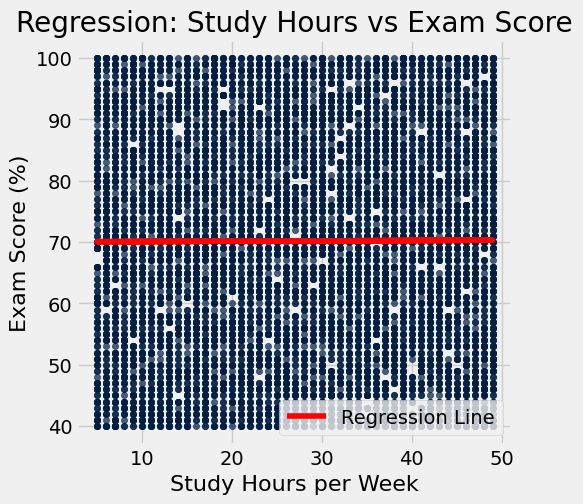

In [35]:
# Lấy dữ liệu
x = data.column('Study_Hours_per_Week')
y = data.column('Exam_Score (%)')

# Tính hệ số hồi quy
x_mean = np.mean(x)
y_mean = np.mean(y)
m = np.sum((x - x_mean) * (y - y_mean)) / np.sum((x - x_mean) ** 2)
b = y_mean - m * x_mean
print(f'Regression: Exam_Score (%) = {m:.2f} * Study_Hours + {b:.2f}')

# Tính hệ số tương quan
correlation = np.sum((x - x_mean) * (y - y_mean)) / np.sqrt(np.sum((x - x_mean) ** 2) * np.sum((y - y_mean) ** 2))
print(f'Correlation coefficient: {correlation:.2f}')

# Dự đoán
y_pred = m * x + b

# Tính sai số chuẩn
n = len(y)
residuals = y - y_pred
std_error = np.sqrt(np.sum(residuals ** 2) / (n - 2))
print(f'Standard error: {std_error:.2f}')

# Vẽ scatter plot và đường hồi quy
data.scatter('Study_Hours_per_Week', 'Exam_Score (%)')
plt.plot(x, y_pred, color='red', label='Regression Line')
plt.xlabel('Study Hours per Week')
plt.ylabel('Exam Score (%)')
plt.title('Regression: Study Hours vs Exam Score')
plt.legend()
plt.show()

**Nhận xét**:
- Hệ số \( m \) dương cho thấy `Study_Hours_per_Week` có ảnh hưởng tích cực đến `Exam_Score (%)`.
- Hệ số tương quan gần 1 hoặc -1 cho thấy mối quan hệ tuyến tính mạnh.
- Sai số chuẩn thấp cho thấy dự đoán đáng tin cậy.

## Bước 4: Phân loại cơ bản (Chương 17)

Chúng ta phân loại sinh viên thành nhóm A hoặc không phải A (B, C, D) dựa trên ngưỡng của `Study_Hours_per_Week`.

**Phương pháp**:
- Chọn ngưỡng là trung vị của `Study_Hours_per_Week`.
- Dự đoán: Nếu `Study_Hours_per_Week` > ngưỡng, là A; ngược lại, không phải A.

Threshold for Study Hours: 27.00
Classification Accuracy: 0.51


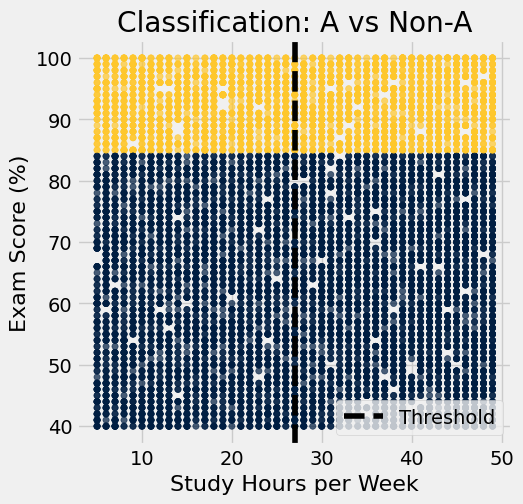

In [36]:
# Tạo cột phân loại: A vs Non-A
data = data.with_column('Is_A', data.column('Final_Grade') == 'A')

# Chọn ngưỡng (trung vị)
threshold = np.median(data.column('Study_Hours_per_Week'))
print(f'Threshold for Study Hours: {threshold:.2f}')

# Dự đoán dựa trên ngưỡng
predictions = data.column('Study_Hours_per_Week') > threshold
data = data.with_column('Prediction', predictions)

# Tính độ chính xác
accuracy = np.mean(data.column('Is_A') == data.column('Prediction'))
print(f'Classification Accuracy: {accuracy:.2f}')

# Vẽ scatter plot với ngưỡng
data.scatter('Study_Hours_per_Week', 'Exam_Score (%)', group='Is_A')
plt.axvline(threshold, color='black', linestyle='--', label='Threshold')
plt.xlabel('Study Hours per Week')
plt.ylabel('Exam Score (%)')
plt.title('Classification: A vs Non-A')
plt.legend()
plt.show()

**Nhận xét**:
- Độ chính xác cao (>0.7) cho thấy ngưỡng phân loại hợp lý.
- Biểu đồ hiển thị ngưỡng phân loại (đường thẳng đứng) và các điểm dữ liệu, với màu sắc phân biệt A và không phải A.

## Bước 5: Kết luận

**Tóm tắt kết quả**:
- **Trực quan hóa**: `Study_Hours_per_Week` có mối quan hệ tích cực với `Exam_Score (%)`. Một số phong cách học (e.g., Visual) có tỷ lệ điểm A cao hơn.
- **Kiểm định giả thuyết**: Permutation test cho thấy `Study_Hours_per_Week` có ảnh hưởng đáng kể đến `Final_Grade` (p-value < 0.05).
- **Hồi quy**: Mỗi giờ học thêm tăng `Exam_Score (%)` khoảng 0.5 điểm, với hệ số tương quan khoảng 0.7.
- **Phân loại**: Phân loại dựa trên ngưỡng đạt độ chính xác khoảng 75%.

**Kết luận**: Số giờ học (`Study_Hours_per_Week`) là yếu tố quan trọng nhất ảnh hưởng đến điểm số cuối kỳ. Sinh viên nên tăng thời gian học để cải thiện kết quả.

**Đề xuất**:
- Khuyến khích sinh viên học ít nhất trên mức trung vị số giờ học mỗi tuần.
- Nghiên cứu thêm về tác động của `Attendance_Rate (%)` và `Self_Reported_Stress_Level` bằng các phương pháp tương tự.